In [1]:
import numpy as np
from finite_difference_time_domain import fdtd_3d, Fdtd3DAnimation
from matplotlib import pyplot as plt

# dark bluered colormap, registers automatically with matplotlib on import
import bluered_dark
import skimage.transform as skf
from scipy import optimize

plt.rcParams.update({
        'figure.figsize': (12/2.54, 9/2.54),
        'figure.subplot.bottom': 0.15,
        'figure.subplot.left': 0.165,
        'figure.subplot.right': 0.90,
        'figure.subplot.top': 0.9,
        'axes.grid': False,
        'image.cmap': 'bluered_dark',
})

plt.close('all')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# constants
c = 2.99792458e8 # speed of light [m/s]
mu0 = 4*np.pi*1e-7 # vacuum permeability [Vs/(Am)]
eps0 = 1/(mu0*c**2) # vacuum permittivity [As/(Vm)]
Z0 = np.sqrt(mu0/eps0) # vacuum impedance [Ohm]

def rel_error(v_out, ref):
    return np.mean(np.abs(v_out - ref))

In [2]:
Nx = 330 # number of grid points in x-direction
Ny = 330 # number of grid points in y-direction
Nz = 5   # number of grid points in z-direction
dr = 200 / Nx * 30e-9 # grid spacing in [m]
time_span = 10e-15 # duration of simulation [s]

# x coordinates
x = np.arange(-int(np.ceil((Nx-1)/2)), int(np.floor((Nx-1)/2)) + 1)*dr
# y coordinates
y = np.arange(-int(np.ceil((Ny-1)/2)), int(np.floor((Ny-1)/2)) + 1)*dr

# source parameters
freq = 500e12 # pulse [Hz]
tau = 1e-15 # pulse width [s]
t0 = 3 * tau
source_width = 2 * dr # width of Gaussian current dist. [grid points]

# grid midpoints
midx = int(np.ceil((Nx-1)/2))
midy = int(np.ceil((Ny-1)/2))
midz = int(np.ceil((Nz-1)/2))

# choose dt small enough
dt = dr / 2 / c
# time array
t = np.arange(0, time_span, dt)

eps_rel = np.ones((Nx, Ny, Nz))

jx = np.zeros((Nx, Ny, Nz), dtype=np.complex128)
jy = np.copy(jx)
jz = np.ones((1, 1, Nz)) * np.exp(- (np.reshape(y, (1, len(y), 1)) ** 2 + 
               np.reshape(x, (len(x), 1, 1)) ** 2) / source_width ** 2)


z_ind = midz  # z-index of field output
output_step = 4  # time steps between field output
Ex, Ey, Ez, Hx, Hy, Hz, t =\
    fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, "ex",
               z_ind, output_step)

ref = np.abs(Ez)

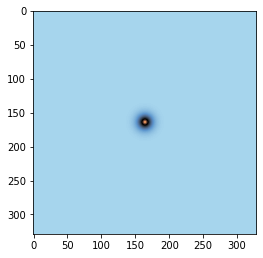

In [3]:
plt.imshow(np.abs(ref[20]))

In [4]:

arr = []
res = []

for i in range(50, 300, 10):
    Nx = i # number of grid points in x-direction
    Ny = i # number of grid points in y-direction
    Nz = 5   # number of grid points in z-direction
    dr = 200 / i * 30e-9 # grid spacing in [m]
    time_span = 10e-15 # duration of simulation [s]

    # x coordinates
    x = np.arange(-int(np.ceil((Nx-1)/2)), int(np.floor((Nx-1)/2)) + 1)*dr
    # y coordinates
    y = np.arange(-int(np.ceil((Ny-1)/2)), int(np.floor((Ny-1)/2)) + 1)*dr

    # source parameters
    freq = 500e12 # pulse [Hz]
    tau = 1e-15 # pulse width [s]
    t0 = 3 * tau
    source_width = 2 * dr # width of Gaussian current dist. [grid points]

    # grid midpoints
    midx = int(np.ceil((Nx-1)/2))
    midy = int(np.ceil((Ny-1)/2))
    midz = int(np.ceil((Nz-1)/2))

    # choose dt small enough
    dt = dr / 2 / c
    # time array
    t = np.arange(0, time_span, dt)

    eps_rel = np.ones((Nx, Ny, Nz))


    jx = np.zeros((Nx, Ny, Nz), dtype=np.complex128)
    jy = np.copy(jx)
    jz = np.ones((1, 1, Nz)) * np.exp(- (np.reshape(y, (1, len(y), 1)) ** 2 + 
                   np.reshape(x, (len(x), 1, 1)) ** 2) / source_width ** 2)
    
    z_ind = midz  # z-index of field output
    output_step = 4  # time steps between field output
    
    Ex, Ey, Ez, Hx, Hy, Hz, t =\
    fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, "ex",
               z_ind, output_step)
    
    ref_s = skf.resize(ref, Ez.shape, order=3)
    ref_s /= np.max(ref_s)
    
    Ez = np.abs(Ez)
    Ez /= np.max(Ez)
    
    res.append(rel_error(ref_s, Ez))
    arr.append(dr)

[5.84875220e+10 1.79408872e+00]
[1.63943926e+11 1.62493509e-01]


<ipython-input-5-d14e0e31c6e2>:2: RuntimeWarning: overflow encountered in power
  return a * x ** b


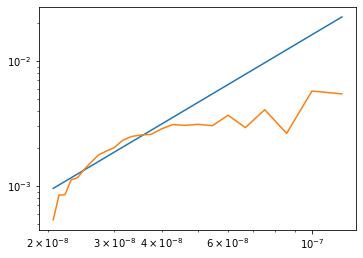

In [5]:
def fit_f(x, a, b):
    return a * x ** b

params, pcov= optimize.curve_fit(fit_f, arr[10:], res[10:], p0=[10000, 2])
perr = np.sqrt(np.diag(pcov))
print(params)
print(perr)
plt.loglog(arr, fit_f(arr, params[0], params[1]))
plt.loglog(arr, res)